# Verbs and Adverbs - Multidimensional Motion Interpolation

by Charles Rose, Bobby Bodenheimer, Michael F. Cohen  
Microsoft Research, 1999

Notebook by Jerome Eippers, 2024

In [1]:
%matplotlib widget
import ipyanimlab as lab
import numpy as np
from ipywidgets import widgets, interact
from matplotlib import pyplot as plt

viewer = lab.Viewer(move_speed=5, width=1280, height=720)

In [2]:
character = viewer.import_usd_asset('AnimLabSimpleMale.usd')

In [3]:
skeleton_q, skeleton_p = lab.utils.m4x4_to_qp(character._mesh.initialpose[np.newaxis, ...])
skeleton_q = skeleton_q[0]
skeleton_p = skeleton_p[0]
for i in range(1, len(character._mesh.bone_parents)):
    parent = character._mesh.bone_parents[i]
    if np.sum(skeleton_q[i] * skeleton_q[parent]) < 0 :
        skeleton_q[i] = -skeleton_q[i]
    print (skeleton_q[i])

[0.5003827  0.49945024 0.50054944 0.49961668]
[ 9.9973589e-01  0.0000000e+00 -1.6612194e-04 -2.2977266e-02]
[ 9.9861598e-01  0.0000000e+00  1.0706510e-06 -5.2593425e-02]
[ 9.9872583e-01  0.0000000e+00 -2.2580546e-06  5.0464451e-02]
[ 9.93440807e-01  0.00000000e+00 -7.12728706e-06  1.14347346e-01]
[ 9.9939764e-01  7.7254699e-06  6.9182365e-06 -3.4703318e-02]
[ 0.00458153  0.6492501  -0.02231333  0.7602338 ]
[ 0.9708736   0.02804367  0.23717654 -0.01911344]
[ 9.8052341e-01  2.7924773e-07  3.8752745e-07 -1.9640252e-01]
[ 1.0000000e+00  5.2041704e-18  1.9515639e-16 -1.3877788e-17]
[ 0.00458592 -0.6492486   0.02230816  0.7602352 ]
[ 0.9708735  -0.02804463 -0.23717697 -0.01911175]
[ 9.8052293e-01  2.6228187e-07 -5.2536613e-08 -1.9640456e-01]
[ 1.0000000e+00 -8.2399365e-17 -4.0072112e-16 -1.3877788e-17]
[-0.01544567 -0.02148361  0.99881214  0.04091749]
[-9.9926788e-01 -9.5026684e-07  3.3747913e-06  3.8258757e-02]
[-0.8199874   0.02756879 -0.04662044 -0.5698133 ]
[-0.97190386  0.04834775 -0.01

In [4]:
target = viewer.create_asset(
    vertices = np.asarray([[9.37, 0.58, -6.81, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [3.58, 0.58, -11.01, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [-3.58, 0.58, -11.01, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [-9.37, 0.58, -6.81, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [-11.58, 0.58, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [-9.37, 0.58, 6.81, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [-3.58, 0.58, 11.01, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [3.58, 0.58, 11.01, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [9.37, 0.58, 6.81, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [11.58, 0.58, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.58, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]], dtype=np.float32),
    indices = np.asarray([[1, 2, 10], [3, 4, 10], [5, 6, 10], [7, 8, 10], [9, 0, 10]], dtype=np.int16)
)

In [5]:
ranges = {
    'walk1_subject5' : [(164,197), (519,554), (1304,1334), (1364,1394), (1457,1489), (1550,1580), (1610,1642)],
    'walk3_subject1' : [(4471,4532), (4654,4708), (4766,4825)], 
    'walk3_subject1_mirror' : [(4682,4739), (4795,4852)], 
}

animations = []
for anim in ranges.keys():
    animmap = lab.AnimMapper(character, keep_translation=False, root_motion=True, mirror=('mirror' in anim), match_effectors=True, local_offsets={'Hips':[0, 2, 0]})
    animation = lab.import_bvh(f'../../resources/lafan1/bvh/{anim.replace("_mirror", "")}.bvh', anim_mapper=animmap)

    for start, end in ranges[anim]:
        new_anim = lab.Anim(animation.quats[start:end,:, :], animation.pos[start:end,:, :], animation.offsets, animation.parents, animation.bones)
        new_anim.quats[:, 0, :], new_anim.pos[:, 0, :] = lab.utils.qp_mul(lab.utils.qp_inv((new_anim.quats[0:1, 0, :], new_anim.pos[0:1, 0, :])), (new_anim.quats[:, 0, :], new_anim.pos[:, 0, :]))
        animations.append(new_anim)

In [6]:
def render(frame):
    
    viewer.begin_display()
    viewer.draw_ground()
    
    for anim in animations:
        f = int(min( anim.pos.shape[0]-1, frame))
        p = (anim.pos[f,...])
        q = (anim.quats[f,...])
        m = lab.utils.quat_to_mat(q, p)
        viewer.draw(character, m)
    
    viewer.end_display()
    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(min=0, max=60)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…

## Canonical Form

In [7]:
'''
timings = np.zeros([len(animations), 6], dtype=np.int32)
for i in range(timings.shape[0]):
    timings[i, -1] = animations[i].pos.shape[0]-1
'''

# pre set values
timings = np.array(
    [[ 0,  7, 11, 23, 27, 32],
       [ 0,  9, 12, 26, 30, 34],
       [ 0,  8, 10, 20, 24, 29],
       [ 0,  7, 10, 20, 24, 29],
       [ 0,  7, 11, 23, 26, 31],
       [ 0,  7, 10, 22, 25, 29],
       [ 0,  8, 11, 23, 26, 31],
       [ 0, 21, 25, 50, 55, 60],
       [ 0, 16, 20, 45, 49, 53],
       [ 0, 18, 23, 48, 52, 58],
       [ 0, 17, 21, 43, 49, 56],
       [ 0, 18, 23, 45, 51, 56]])

In [8]:
def render(frame, index, onspot=False):

    anim = animations[index]
    timing = timings[index]
    
    f = int(min( anim.pos.shape[0]-1, frame))
    p = (anim.pos[f,...]).copy()
    q = (anim.quats[f,...]).copy()

    if onspot:
        p[0] = 0
        q[0] = np.array([1,0,0,0], dtype=np.float32)
        
    _, ogp = lab.utils.quat_fk(q, p, anim.parents)
    ogp[:, 1] = 0
        
    contacts_matrices = np.eye(4, dtype=np.float32)[np.newaxis,...].repeat(2, axis=0)
    contacts_matrices[:, 1, 3] = -10
    
    m = lab.utils.quat_to_mat(q, p)
    
    if frame < timing[2] or frame > timing[3]:
        contacts_matrices[0, :3, 3] = ogp[character.bone_index('LeftFoot')]
    if frame >= timing[1] and frame < timing[4]:
        contacts_matrices[1, :3, 3] = ogp[character.bone_index('RightFoot')]
    
    
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, m)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, m)
    viewer.draw(target, contacts_matrices)
    viewer.end_display()
    viewer.execute_commands()

    
timeline = lab.Timeline(min=0, max=animations[0].pos.shape[0]-1)
combo = widgets.Dropdown(description='Animation', options=range(len(animations)), value=0)
output = widgets.Label(value=str(timings[0]))

def combo_switch(change):
    timeline.max = animations[change.new].pos.shape[0]-1
    output.value =str(timings[change.new])
combo.observe(combo_switch , names='value')

bt_rd = widgets.Button(description='Right Down')
bt_ru = widgets.Button(description='Right Up')
bt_ld = widgets.Button(description='Left Down')
bt_lu = widgets.Button(description='Left Up')

buttons = widgets.HBox([bt_rd, bt_lu, bt_ld, bt_ru])
def on_click(event):
    step = ['Begin','Right Down','Left Up','Left Down','Right Up','End'].index(event.description)
    timings[combo.value, step] = timeline.value
    output.value =str(timings[combo.value])
    
bt_rd.on_click(on_click)
bt_ru.on_click(on_click)
bt_ld.on_click(on_click)
bt_lu.on_click(on_click)

interact(
    render, 
    frame=timeline,
    index=combo
)
display(buttons)
display(output)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Label(value='[ 0  7 11 23 27 32]')

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…

### Make the animation loop

In [9]:
def make_looping_animation(anim, timing):
    
    # copy to not alter
    quats = anim.quats.copy()
    pos = anim.pos.copy()
    
    # local offset (we take the first pose relative to the last pose)
    # we take it all, but then we will not use the root so we will have the first pose relative to the last in the position of the last frame.
    offq, offp = lab.utils.qp_mul(lab.utils.qp_inv((quats[-1,...], pos[-1,...])), (quats[0,...], pos[0,...])) 
    
    # global positions ( to get feet )
    gq, gp = lab.utils.quat_fk(quats, pos, anim.parents)
    
    # global last position
    lastq, lastp = quats[0, :, :].copy(), pos[0, :, :].copy()
    lastq[0, :], lastp[0, :] = quats[-1, 0, :], pos[-1, 0, :]
    lgq, lgp = lab.utils.quat_fk(lastq, lastp, anim.parents)
    offgq, offgp = lab.utils.qp_mul(lab.utils.qp_inv((gq[-1,...], gp[-1,...])), (lgq, lgp)) 
    
    # lerp local offset
    for f in range(quats.shape[0]):
        t = np.array([float(f)/float(quats.shape[0]-1)])
        identity = lab.utils.remove_quat_discontinuities(np.concatenate(
            [
                offq[np.newaxis,...], 
                np.array([1,0,0,0], dtype=np.float32)[np.newaxis,:].repeat(quats.shape[1], axis=0)[np.newaxis,...]
            ]))[1]
        oq = lab.utils.quat_normalize((1.0 -t ) * identity + t * offq)
        op = t * offp
        
        quats[f, 1:, :], pos[f, 1:, :] = lab.utils.qp_mul((quats[f, 1:, :], pos[f, 1:, :]), (oq[1:], op[1:]))
        
    # global left foot (only moves when the foot is in the air, in the middle of the animation)
    feet_ids = np.array([character.bone_index('LeftFoot'), character.bone_index('RightFoot')], dtype=np.int8)
    footid = feet_ids[0]
    for f in range(timing[2], timing[5]+1):
        t = np.minimum(np.array([float(f-timing[2]+1)/float(timing[3]-timing[2])]), 1)  
        identity = lab.utils.remove_quat_discontinuities(np.concatenate(
            [
                offgq[np.newaxis,footid,:], 
                np.array([1,0,0,0], dtype=np.float32)[np.newaxis,:]
            ]))[1]
        
        oq = lab.utils.quat_normalize((1.0 - t ) * identity  + t * offgq[np.newaxis,footid,:])
        op = t * offgp[footid,:]
        
        gq[f, footid, :], gp[f, footid, :] = lab.utils.qp_mul((gq[f, footid, :], gp[f, footid, :]), (oq, op))
        
    # global right foot (only moves when the foot is in the air, at the end of the animation)
    footid = feet_ids[1]
    for f in range(timing[4], timing[5]+1):
        t = np.minimum(np.array([float(f-timing[4]+1)/float(timing[5]-timing[4])]), 1)    
        identity = lab.utils.remove_quat_discontinuities(np.concatenate(
            [
                offgq[np.newaxis,footid,:], 
                np.array([1,0,0,0], dtype=np.float32)[np.newaxis,:]
            ]))[1]
        
        oq = lab.utils.quat_normalize((1.0 - t ) * identity  + t * offgq[np.newaxis,footid,:])
        op = t * offgp[footid,:]
        
        gq[f, footid, :], gp[f, footid, :] = lab.utils.qp_mul((gq[f, footid, :], gp[f, footid, :]), (oq, op))
    
    # create the animation and the feet ik
    quats, pos = lab.utils.limb_ik(quats, pos, anim.parents, anim.bones, gq[:, feet_ids, :], gp[:, feet_ids, :])
    quats = lab.utils.quat_normalize(quats)
    quats = lab.utils.remove_quat_discontinuities(quats)
    
    return lab.Anim(quats, pos, anim.offsets, anim.parents, anim.bones)

In [10]:
animations = [make_looping_animation(anim, timing) for anim, timing in zip(animations, timings)]

In [11]:
def render(frame, index, onspot=False):

    anim = animations[index]
    timing = timings[index]
    
    f = int(min( anim.pos.shape[0]-1, frame))
    p = (anim.pos[f,...]).copy()
    q = (anim.quats[f,...]).copy()

    if onspot:
        p[0] = 0
        q[0] = np.array([1,0,0,0], dtype=np.float32)
        
    _, ogp = lab.utils.quat_fk(q, p, anim.parents)
    ogp[:, 1] = 0
        
    contacts_matrices = np.eye(4, dtype=np.float32)[np.newaxis,...].repeat(2, axis=0)
    contacts_matrices[:, 1, 3] = -10
    
    m = lab.utils.quat_to_mat(q, p)
    
    if frame < timing[2] or frame > timing[3]:
        contacts_matrices[0, :3, 3] = ogp[character.bone_index('LeftFoot')]
    if frame >= timing[1] and frame < timing[4]:
        contacts_matrices[1, :3, 3] = ogp[character.bone_index('RightFoot')]
    
    
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, m)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, m)
    viewer.draw(target, contacts_matrices)
    viewer.end_display()
    viewer.execute_commands()

    
timeline = lab.Timeline(min=0, max=animations[0].pos.shape[0]-1)
combo = widgets.Dropdown(description='Animation', options=range(len(animations)), value=0)

def combo_switch(change):
    timeline.max = animations[change.new].pos.shape[0]-1
combo.observe(combo_switch , names='value')

interact(
    render, 
    frame=timeline,
    index=combo
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…

### Resample

In [12]:
def warp_curve(timewarp_curve, curve):
    floor_curve = np.floor(timewarp_curve).astype(np.int32)
    floor_curve_1 = np.minimum(floor_curve+1, curve.shape[0]-1)
    t = timewarp_curve - floor_curve
    t = t[np.newaxis, :].repeat(np.prod(curve.shape[1:]), axis=-1).reshape(timewarp_curve.shape[0], *curve.shape[1:])
    return ((1.0 - t ) * curve[floor_curve, ...]) + (t * curve[floor_curve_1, ...])

In [13]:
#6 keytimes
#80 intervales
#total frame (6-1)*80 + 1

resampled_animations = []
for anim, timing in zip(animations, timings):
    q = np.zeros([401, character.bone_count(), 4])
    p = np.zeros([401, character.bone_count(), 3])
    
    for i in range(5):
        q[i*80: i*80+81, ...] = warp_curve(np.linspace(timing[i], timing[i+1], 81), anim.quats)
        p[i*80: i*80+81, ...] = warp_curve(np.linspace(timing[i], timing[i+1], 81), anim.pos)
        
    q = lab.utils.quat_normalize(q)
    q = lab.utils.remove_quat_discontinuities(q)

    # set all the quaternion in the same base as the skeleton
    neg = np.sum(q * skeleton_q[np.newaxis,...], axis=-1) < 0
    q[neg] = -q[neg]
    
    resampled_animations.append(lab.Anim(q, p, anim.offsets, anim.parents, anim.bones))

In [14]:
def render(frame, index, onspot=False):

    anim = resampled_animations[index]
    timing = timings[index]
    
    f = frame
    p = (anim.pos[f,...]).copy()
    q = (anim.quats[f,...]).copy()

    if onspot:
        p[0] = 0
        q[0] = np.array([1,0,0,0], dtype=np.float32)
    
    m = lab.utils.quat_to_mat(q, p)
    
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, m)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, m)
    viewer.end_display()
    viewer.execute_commands()

    
timeline = lab.Timeline(min=0, max=400)
combo = widgets.Dropdown(description='Animation', options=range(len(resampled_animations)), value=0)


interact(
    render, 
    frame=timeline,
    index=combo
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…

### Uniform B Spline

In [15]:
from scipy.optimize import minimize

# how many points to use between each control points
interval_count = 21
point_count = 23

# b spline basis
BS = np.array([[-1,3,-3,1],[3,-6,0,4],[-3,3,3,1], [1,0,0,0]], dtype=np.double).T/6.0
t = np.linspace(0, 1, interval_count)
T = np.column_stack([t**3, t**2, t, np.ones_like(t)])

# compute b spline
def bspline(P):
    Pts = P #np.concatenate([P[0:1], P[0:1], P, P[-1:], P[-1:]])
    segment = int(Pts.shape[0]-3)
    output = np.zeros([segment*(interval_count-1)+1])
    index = 0
    for s in range(segment):
        output[index*(interval_count-1):index*(interval_count-1)+interval_count] =  np.dot(T, np.dot(BS, Pts[index:index+4])) 
        index += 1
    return output

# Define the error function to minimize
def error_function(y_points, y_actual):

    # Evaluate the cubic b spline
    y_spline = bspline(y_points)

    # Calculate the error
    return np.sum((y_spline - y_actual)**2)

# x_points position to initial guess
x_points = np.concatenate([[0,0],np.linspace(0, 400, point_count-4, dtype=np.int32),[400,400]])

def convert_curve(y_actual):
    initial_guess = y_actual[x_points]

    # Minimize the error function to find optimal y values
    result = minimize(error_function, initial_guess, y_actual)

    # Optimal points
    return result.x

In [16]:
q = np.zeros([len(animations), point_count, character.bone_count(), 4])
p = np.zeros([len(animations), point_count, character.bone_count(), 3])

for i, anim in enumerate(resampled_animations):    
    for b in range(character.bone_count()):
        q[i, :, b, 0] = convert_curve(anim.quats[:, b, 0])
        q[i, :, b, 1] = convert_curve(anim.quats[:, b, 1])
        q[i, :, b, 2] = convert_curve(anim.quats[:, b, 2])
        q[i, :, b, 3] = convert_curve(anim.quats[:, b, 3])
        p[i, :, b, 0] = convert_curve(anim.pos[:, b, 0])
        p[i, :, b, 1] = convert_curve(anim.pos[:, b, 1])
        p[i, :, b, 2] = convert_curve(anim.pos[:, b, 2])
        
bpline_animations = lab.Anim(q, p, anim.offsets, anim.parents, anim.bones)

Text(0, 0.5, 'Value')

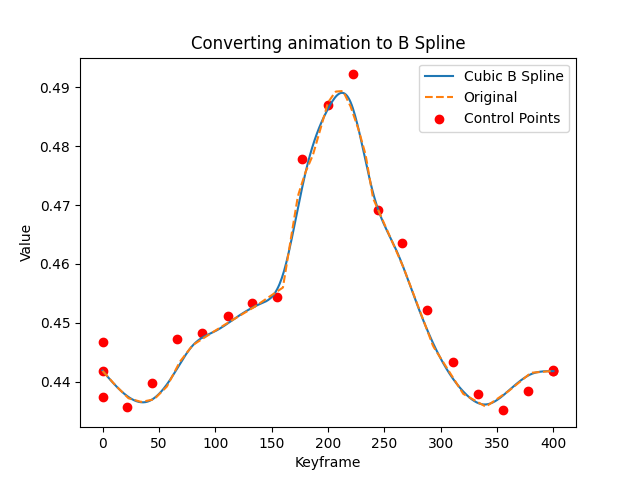

In [17]:
# compute a curve to show the mapping
computed = bspline(bpline_animations.quats[5, :, 1, 1])

# x points along keyframes
x_actual = np.arange(401, dtype=np.int32)

# Plotting the original function, fixed points, and the cubic spline curve
fig1, (ax1) = plt.subplots(1, 1)
ax1.plot(x_actual, computed, label='Cubic B Spline')
ax1.plot(x_actual, resampled_animations[5].quats[:, 1, 1], label='Original', linestyle='dashed')
ax1.scatter(x_points, bpline_animations.quats[5, :, 1, 1], label='Control Points', color='red')
ax1.legend()
ax1.set_title('Converting animation to B Spline')
ax1.set_xlabel('Keyframe')
ax1.set_ylabel('Value')

In [18]:
def render(frame, index, onspot=False):
  
    # convert the entire animation :
    f = frame
    q = np.zeros([101, character.bone_count(), 4])
    p = np.zeros([101, character.bone_count(), 3])
    
    #interval_count = (frame_count-4 + point_count)/(point_count-3)
    interval_count = 6
    
    # b spline basis
    BS = np.array([[-1,3,-3,1],[3,-6,0,4],[-3,3,3,1], [1,0,0,0]], dtype=np.double).T/6.0
    t = np.linspace(0, 1, interval_count)
    T = np.column_stack([t**3, t**2, t, np.ones_like(t)])

    # compute b spline
    def bspline(Pts):
        segment = int(Pts.shape[0]-3)
        output = np.zeros([segment*(interval_count-1)+1])
        index = 0
        for s in range(segment):
            output[index*(interval_count-1):index*(interval_count-1)+interval_count] =  np.dot(T, np.dot(BS, Pts[index:index+4])) 
            index += 1
        return output
    
    # convert frames
    for b in range(character.bone_count()):
        q[:, b, 0] = bspline(bpline_animations.quats[index, :, b, 0])
        q[:, b, 1] = bspline(bpline_animations.quats[index, :, b, 1])
        q[:, b, 2] = bspline(bpline_animations.quats[index, :, b, 2])
        q[:, b, 3] = bspline(bpline_animations.quats[index, :, b, 3])
        p[:, b, 0] = bspline(bpline_animations.pos[index, :, b, 0])
        p[:, b, 1] = bspline(bpline_animations.pos[index, :, b, 1])
        p[:, b, 2] = bspline(bpline_animations.pos[index, :, b, 2])

    q = lab.utils.quat_normalize(q)

    
    generic_time = 0
    while f > timings[index, 5]:
        f -= timings[index, 5]
    
    for i in range(5):
        if f <= timings[index, i+1]:
            generic_time = float(i) + (float(f) - timings[index, i])/(timings[index, i+1] - timings[index, i])
            break

    generic_time *= 100/5 # use 100 because we read the bspline with 100 values, and 5 because the timings will return a value between 0 and 5 for the generic time
        
    # pick the wanted frame
    q = q[int(generic_time)]
    p = p[int(generic_time)]
        
    if onspot:
        p[0] = 0
        q[0] = np.array([1,0,0,0], dtype=np.float32)
    
    m = lab.utils.quat_to_mat(q, p)
    
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, m)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, m)
    viewer.end_display()
    viewer.execute_commands()

    
timeline = lab.Timeline(min=0, max=1000)
combo = widgets.Dropdown(description='Animation', options=range(bpline_animations.pos.shape[0]), value=0)


interact(
    render, 
    frame=timeline,
    index=combo
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…

## Verb Construction

### RBF

In [19]:
class RBF:
    
    @staticmethod
    def B3 (x):
        x1 = x-1
        bezier = (1.0/6.0) * (-(x1**3) + 3*(x1**2) - 3*x1 + 1)
        bezier[x>2.0] = 0
        bezier[x<1.0] = (1.0/6.0)*(3*(x**3)-6*(x**2)+4)[x<1.0]
        return bezier
        
    
    def __init__(self, adverbs):
        """
        param adverbs : tensor of shape [i, j] with i the number of data point and j the number of adverb
        """
        self._adverbs = adverbs
        c = np.swapaxes(adverbs[np.newaxis, ...], 0, 2)
        r = np.swapaxes(adverbs.T[np.newaxis, ...], 0, 1)
        distances = np.sqrt(np.sum((c - r)**2, axis=0))
        
        self._alphas = np.zeros([adverbs.shape[0]])
        for i in range(adverbs.shape[0]):
            self._alphas[i] = np.min(distances[i, np.arange(adverbs.shape[0]) != i])
            
        self._D = RBF.B3(distances / self._alphas[np.newaxis, :])
        self._linear_adverbs = np.column_stack([np.ones(adverbs.shape[0]), adverbs])
        
        
    def fit(self, p):
        """
        param p : tensor of shape [i] with i being the adverbs values for each of the data point
        returns a tuple with a tensor for the linear coefficients and a tensor for the radial coefficients
        """
        linear_coefficients = np.linalg.lstsq(self._linear_adverbs, p, rcond=None)[0]
        residuals = p - np.dot(self._linear_adverbs, linear_coefficients)
        radial_coefficients = np.linalg.solve(self._D, residuals)
        
        return linear_coefficients, radial_coefficients

    
    def __call__(self, linear_coefficients, radial_coefficients, p):
        """
        param linear_coefficients : the linear coefficients returned by the fit
        param radial_coefficients : the radial_coefficients returned by the fit
        param p : tensor of shape [i, j] with i being the number of points to interpolate et j beeing the adverbs values
        return : a tensor with all the interpolated values
        """
        linear = np.dot(np.column_stack([np.ones(p.shape[0]), p]), linear_coefficients)
        
        c = np.swapaxes(p[np.newaxis, ...], 0, 2)
        r = np.swapaxes(self._adverbs.T[np.newaxis, ...], 0, 1)
        D = RBF.B3(np.sqrt(np.sum((c - r)**2, axis=0)) / self._alphas[np.newaxis, :])

        return linear + np.dot(D, radial_coefficients)

### Define adverbs

In [20]:
# 2 dimensions : first is the rotation, second is the style

adverbs = np.zeros([len(animations), 2])
for i, anim in enumerate(animations):
    direction = lab.utils.quat_mul_vec(anim.quats[-2, 0, :], np.asarray([0.0, 0.0, 1.0])) #-2 because one animation is rotating just too far
    adverbs[i, 0] = np.arctan2(direction[0], direction[2])
adverbs[7:, 1] = 1
adverbs

array([[ 0.11793686,  0.        ],
       [ 0.76773497,  0.        ],
       [ 1.60984876,  0.        ],
       [ 3.0775927 ,  0.        ],
       [-1.74392164,  0.        ],
       [-1.30536708,  0.        ],
       [-2.0454693 ,  0.        ],
       [ 0.22568389,  1.        ],
       [-0.78203833,  1.        ],
       [-1.0453719 ,  1.        ],
       [ 1.33415495,  1.        ],
       [ 0.84432514,  1.        ]])

### Build RBF

In [21]:
animations_rbf = RBF(adverbs)

timings_linear_coefs = np.zeros([6,3])
timings_radial_coefs = np.zeros([6,12])

for i in range(6):
    timings_linear_coefs[i,:], timings_radial_coefs[i, :] = animations_rbf.fit(timings[:, i])
    
animation_linear_coefs = np.zeros([point_count, character.bone_count(), 7, 3])
animation_radial_coefs = np.zeros([point_count, character.bone_count(), 7,12])

for i in range(point_count):
    for b in range(character.bone_count()):
        animation_linear_coefs[i, b, 0, :], animation_radial_coefs[i, b, 0, :] = animations_rbf.fit(bpline_animations.quats[:, i, b, 0])
        animation_linear_coefs[i, b, 1, :], animation_radial_coefs[i, b, 1, :] = animations_rbf.fit(bpline_animations.quats[:, i, b, 1])
        animation_linear_coefs[i, b, 2, :], animation_radial_coefs[i, b, 2, :] = animations_rbf.fit(bpline_animations.quats[:, i, b, 2])
        animation_linear_coefs[i, b, 3, :], animation_radial_coefs[i, b, 3, :] = animations_rbf.fit(bpline_animations.quats[:, i, b, 3])
        animation_linear_coefs[i, b, 4, :], animation_radial_coefs[i, b, 4, :] = animations_rbf.fit(bpline_animations.pos[:, i, b, 0])
        animation_linear_coefs[i, b, 5, :], animation_radial_coefs[i, b, 5, :] = animations_rbf.fit(bpline_animations.pos[:, i, b, 1])
        animation_linear_coefs[i, b, 6, :], animation_radial_coefs[i, b, 6, :] = animations_rbf.fit(bpline_animations.pos[:, i, b, 2])

### Interpolate Adverbs

interactive(children=(FloatSlider(value=0.0, description='value', layout=Layout(width='800px'), max=1.0, step=…

<function __main__.test_value(value)>

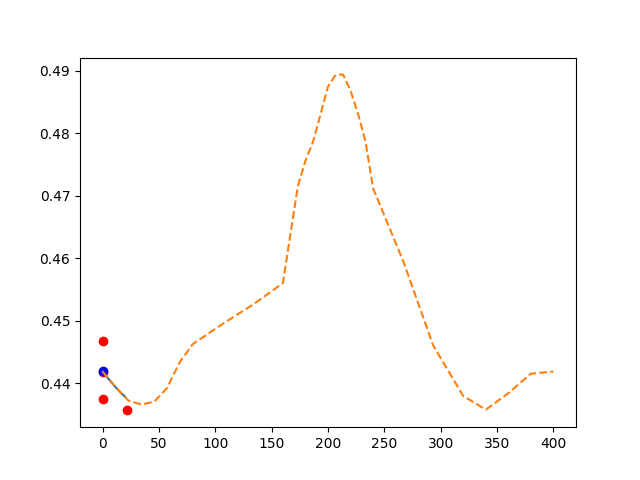

In [22]:
# showing picking the right points
fig2, (ax2) = plt.subplots(1, 1)
ax2.set_title('Converting animation to B Spline')
ax2.set_xlabel('Keyframe')
ax2.set_ylabel('Value')
    
def test_value(value):
    
    BS = np.array([[-1,3,-3,1],[3,-6,0,4],[-3,3,3,1], [1,0,0,0]], dtype=np.double).T/6.0
    t = np.linspace(0, 1, 101)
    T = np.column_stack([t**3, t**2, t, np.ones_like(t)])
    
    
    index = int(value*20)
    index = np.minimum(index, 19)
    ratio = (value*20)-index
    pts = bpline_animations.quats[5, :, 1, 1][index:index+4]
    
    #display(index, ratio)

    y = np.dot(T, np.dot(BS, pts))
    

    # x points along keyframes
    x_actual = np.arange(401, dtype=np.int32)
    ax2.cla()
    
    ax2.plot((index+t)*400/20, y, label='Cubic B Spline')

    ax2.plot(x_actual, resampled_animations[5].quats[:, 1, 1], label='Original', linestyle='dashed')
    ax2.scatter(x_points[index:index+4], pts, label='Control Points', color='red')
    ax2.scatter((index+ratio)*400/20, y[int(ratio*100)], label='value', color='blue')
    

interact(
    test_value, 
    value=widgets.FloatSlider(min=0, max=1, step=0.001, value=0, layout = widgets.Layout(width='800px'))
)

In [31]:
from dataclasses import dataclass, field

@dataclass(repr=True)
class Buffer:
    lastframe:float = 0
    currentframe:float = 0
    last_quat:np.array = np.array([1,0,0,0])
    last_pos:np.array = np.zeros(3)
    current_quat:np.array = np.array([1,0,0,0])
    current_pos:np.array = np.zeros(3)
    generic_time:float = 0
    lf_q:np.array = np.array([1,0,0,0])
    lf_p:np.array = np.zeros(3)
    rf_q:np.array = np.array([1,0,0,0])
    rf_p:np.array = np.zeros(3)

buffer = Buffer()
    
def render(frame, angle, mood, lock_feet=False):
    
    if frame == 0:
        buffer.currentframe = 0
        buffer.current_quat = np.array([1,0,0,0])
        buffer.current_pos = np.zeros(3)
        buffer.last_quat = np.array([1,0,0,0])
        buffer.last_pos = np.zeros(3)
        buffer.lastframe = 0
    elif frame > buffer.lastframe:
        buffer.currentframe += 1
    elif frame < buffer.lastframe:
        buffer.currentframe -= 1
        
    buffer.lastframe = buffer.currentframe
    
    # adverbs
    control = np.asarray([angle , mood])[np.newaxis,:]
    
    # compute time table
    computed_times = np.zeros([6], dtype=np.float32)
    for i in range(6):
        computed_times[i] = animations_rbf(timings_linear_coefs[i], timings_radial_coefs[i], control)[0]
            
    # get the generic time
    while (buffer.currentframe < 0):
        buffer.currentframe += int(computed_times[5])
        buffer.last_quat = np.array([1,0,0,0])
        buffer.last_pos = np.zeros(3)
    while (buffer.currentframe > computed_times[5]):
        buffer.currentframe -= int(computed_times[5])
        buffer.last_quat = np.array([1,0,0,0])
        buffer.last_pos = np.zeros(3)
        
        
    frame = buffer.currentframe
        
    buffer.generic_time = 0
    for i in range(5):
        if frame <= computed_times[i+1]:
            buffer.generic_time = float(i) + (float(frame) - computed_times[i])/(computed_times[i+1] - computed_times[i])
            break
    buffer.generic_time /= 5.0
    
    # find control points
    index = int(buffer.generic_time*20)
    index = np.minimum(index, 19)
    ratio = (buffer.generic_time*20)-index
    
    # interplate points
    points = np.zeros([4, character.bone_count(), 7])
    for i in range(4):
        for b in range(character.bone_count()):
            for j in range(7):
                points[i, b, j] = animations_rbf(animation_linear_coefs[i+index, b, j], animation_radial_coefs[i+index, b, j], control)[0]

    
    # compute spline value
    BS = np.array([[-1,3,-3,1],[3,-6,0,4],[-3,3,3,1], [1,0,0,0]], dtype=np.double).T/6.0
    t = np.linspace(0, 1, 33)
    T = np.column_stack([t**3, t**2, t, np.ones_like(t)])
    
    q = np.zeros([33, character.bone_count(), 4])
    p = np.zeros([33, character.bone_count(), 3])
    
    for b in range(character.bone_count()):
        q[:, b, 0] = np.dot(T, np.dot(BS, points[:, b, 0]))
        q[:, b, 1] = np.dot(T, np.dot(BS, points[:, b, 1]))
        q[:, b, 2] = np.dot(T, np.dot(BS, points[:, b, 2]))
        q[:, b, 3] = np.dot(T, np.dot(BS, points[:, b, 3]))
        p[:, b, 0] = np.dot(T, np.dot(BS, points[:, b, 4]))
        p[:, b, 1] = np.dot(T, np.dot(BS, points[:, b, 5]))
        p[:, b, 2] = np.dot(T, np.dot(BS, points[:, b, 6]))

    q = lab.utils.quat_normalize(q)

    frame_index = int(ratio*32)

    q = q[frame_index]
    p = p[frame_index]
    
    off_quat, off_pos = lab.utils.qp_mul(lab.utils.qp_inv((buffer.last_quat, buffer.last_pos)), (q[0], p[0]))
    buffer.current_quat, buffer.current_pos = lab.utils.qp_mul((buffer.current_quat, buffer.current_pos), (off_quat, off_pos))
    buffer.current_quat = lab.utils.quat_normalize(buffer.current_quat)

    buffer.last_quat, buffer.last_pos = q[0].copy(), p[0].copy()
    
    q[0] = buffer.current_quat.copy()
    p[0] = buffer.current_pos.copy()
    
    # global positions ( to get feet )
    gq, gp = lab.utils.quat_fk(q, p, bpline_animations.parents)
    
    if buffer.generic_time > 1.9/6. and buffer.generic_time < 5.1/6. :
        buffer.lf_q = gq[character.bone_index('LeftFoot')]
        buffer.lf_p = gp[character.bone_index('LeftFoot')]
        
    if buffer.generic_time < 2.5/6. or buffer.generic_time > 4/6. :
        buffer.rf_q = gq[character.bone_index('RightFoot')]
        buffer.rf_p = gp[character.bone_index('RightFoot')]
    
    temp_q, temp_p = lab.utils.limb_ik(
        q[np.newaxis,...], p[np.newaxis,...], 
        bpline_animations.parents, bpline_animations.bones,
        np.concatenate([buffer.lf_q[np.newaxis,...], buffer.rf_q[np.newaxis,...]])[np.newaxis,...], 
        np.concatenate([buffer.lf_p[np.newaxis,...], buffer.rf_p[np.newaxis,...]])[np.newaxis,...]
    )
    if lock_feet:
        q = temp_q[0]
        p = temp_p[0]
    
    m = lab.utils.quat_to_mat(q, p)
    
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, m)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, m)
    viewer.end_display()

    viewer.disable(depth_test=True)
   
    viewer.draw_axis(character.world_skeleton_xforms(m), 5)
    viewer.draw_lines(character.world_skeleton_lines(m))

    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(min=0, max=5000),
    angle=widgets.FloatSlider(min=-3, max=3, step=0.01, value=0),
    mood=widgets.FloatSlider(min=0, max=1, step=0.01, value=0)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-20.99999999999998, camera_pos=[-420.3744845568191, 4…